In [178]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import product
from PIL import Image
from scipy.io import loadmat
from scipy.spatial.distance import cdist, pdist
from sklearn.cluster import AgglomerativeClustering

# PART 1

In [179]:
matdata = loadmat('Data/Lab 6/ex6data1.mat')
X = matdata['X']
print(X.shape)

(300, 2)


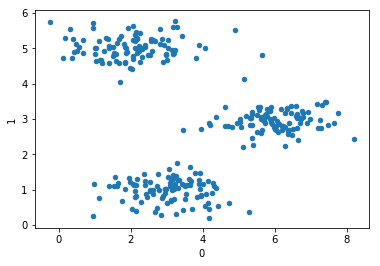

In [180]:
pd.DataFrame(X).plot.scatter(x=0, y=1)

In [181]:
def J_func(x, μ, c):
    """
    Parameters:
        x: array, shape (m, n)
        c: array, shape (m, )

    Returns:
        J: number
    """
    K = len(μ)
    N, M = x.shape
    J = 0
    for k in range(K):
        idx = np.where(c == k)
        J += cdist(x[idx], [μ[k]], 'sqeuclidean').sum()
    return J / M


def k_init_one(k, x):
    """
    Parameters:
        k: number of clusters
        x: array, shape (n, m)
        
    Returns:
        μ: array, shape (k, m)
    """
    μ = np.array([random.choice(x) for _ in range(k)])
    return μ


def k_init(k, x, niter):
    """
    Parameters:
        k: number of clusters
        x: array, shape (n, m)
        
    Returns:
        μ: array, shape (k, m)
    """
    n, m = x.shape

    μ_vec = np.array([k_init_one(k, x) for _ in range(niter)])
    c_vec = np.array([k_cluster_assignment(x, μ) for μ in μ_vec]) 
    J_vec = np.array([J_func(x, μ, c) for μ, c in zip(μ_vec, c_vec)])
    
    idx = J_vec.argmin()
    return μ_vec[idx]


def k_cluster_assignment(x, μ):
    """
    k: number of clusters
    Parameters:
        x: array, shape (n, m)
        μ: array, shape (k, m)
        
    Returns:
        c: array, shape (n, )
    """
    dist = cdist(x, μ)
    c = np.argmin(dist, axis=1)
    return c
        
    
def k_update_center(x, μ, c):
    """
    k: number of clusters
    Parameters:
        x: array, shape (n, m)
        μ: array, shape (k, m)
        c: array, shape (n, )

    Returns:
        μ_new: array, shape (k, m)
    """
    N, M = x.shape
    K = len(μ)
    
    μ_new = np.zeros(K*M).reshape(K, M)
    
    for k in range(K):
        idx = np.where(c == k)
        μ_new[k] = x[idx].mean(axis=0)
    return μ_new


def k_mean(k, x, *, ninititer=100, niter=20, hist=True, eps=10**(-6)):
    n, m = x.shape
    # Init cluster centers
    μ = k_init(k, x, niter=ninititer)
    if hist:
        μ_hist = [μ]
    
    # Eval clusters for each Xi
    c = k_cluster_assignment(x, μ)
    J = J_func(x, μ, c)
    for i in range(niter):
        μ_new = k_update_center(x, μ, c)
        c_new = k_cluster_assignment(x, μ_new)
        J_new = J_func(x, μ_new, c)

        if (c_new == c).all():
            print(f'{i}: c doesn\'t change')
            
        if abs(J_new - J) < eps:
            break

        # Update params
        c = c_new
        J, μ = J_new, μ_new
        hist and μ_hist.append(μ)    

    print(i)
    if hist:
        return np.array(μ_hist), c
    return μ, c

In [182]:
k = 3
μ_hist, c = k_mean(k, X, ninititer=1)

1: c doesn't change
2: c doesn't change
2


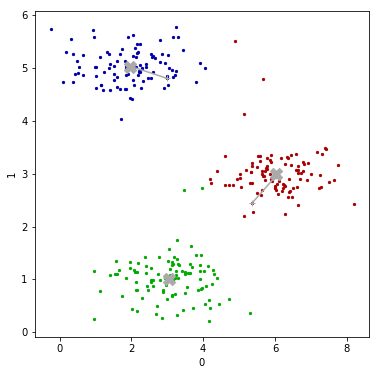

In [201]:
fix, ax = plt.subplots(1, 1, figsize=(6,6))
df = pd.DataFrame(X)

p_colors = ['#aa0000', '#00aa00', '#0000aa']
mv_colors = ['#aaaaaa', '#aaaaaa', '#aaaaaa']
for i in range(k):
    idx = np.where(c == i)
    df.loc[idx].plot.scatter(x=0, y=1, ax=ax, c=p_colors[i], marker='.')

    x, y = μ_hist[:, i, 0], μ_hist[:, i, 1]
    ax.plot(x, y, c=mv_colors[i],  marker='+')
    ax.scatter(x[-1], y[-1], marker='X', c=mv_colors[i], s=150)

# PART 2

In [44]:
def rgb2int(r, g, b):
    return int('%02x%02x%02x' % (r, g, b), 16)


def to_X(A):
    height, width, _ = A.shape
    return np.array([
        # x  y   Red         Green       Blue
        [ x, y, rgb2int(A[x, y, 0], A[x, y, 1], A[x, y, 2]) ]
        for x, y in product(range(height), range(width))  
    ])

(128, 128, 3)
(16384, 3)
42: c doesn't change
43: c doesn't change
43


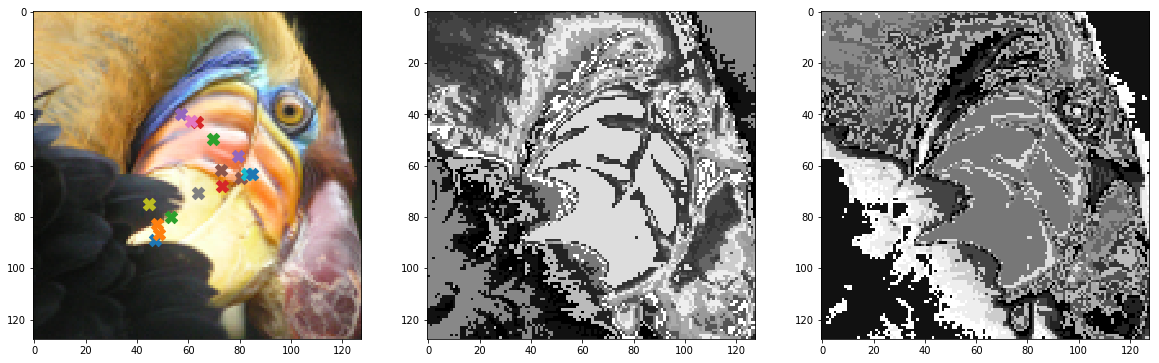

In [218]:
matdata = loadmat('Data/Lab 6/bird_small.mat')
A = matdata['A']
HEIGHT, WIDTH, _ = A.shape
print(A.shape)

X = to_X(A)
print(X.shape)

# Subplots
_, ax = plt.subplots(1, 3, figsize=(20, 30))
ax[0].imshow(A)

# K-mean Clustering
μ, c = k_mean(16, X, niter=1000, hist=False)
cmap = [X[np.where(c == ci)][0][2] for ci in range(16)]

img = c.reshape(HEIGHT, WIDTH)
ax[1].imshow(img, cmap='gray')
for μi in μ:
    ax[0].scatter(μi[1], μi[0], s=150, marker='X')
    
# Hierarchical Clustering
clustering = AgglomerativeClustering(n_clusters=16).fit(X)
c = clustering.labels_
img = c.reshape(HEIGHT, WIDTH)
ax[2].imshow(img, cmap='gray')

A:  (277, 371, 3)
X:  (102767, 3)
6: c doesn't change
7: c doesn't change
7


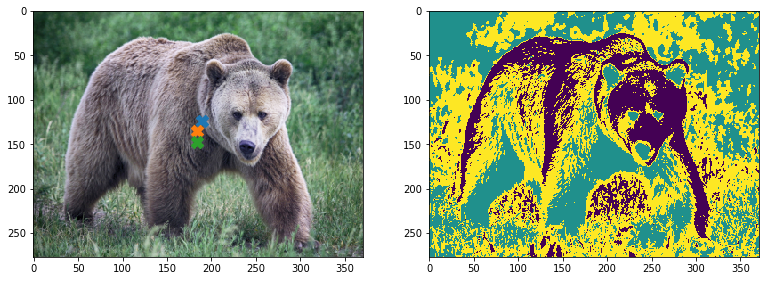

In [156]:
image = Image.open('Data/Lab 6/grizzly-1.png')
A = np.array(image)
HEIGHT, WIDTH, _ = A.shape
print('A: ', A.shape)

X = to_X(A)
print('X: ', X.shape)


_, ax = plt.subplots(1, 2, figsize=(13, 26))
ax[0].imshow(A)

μ, c = k_mean(3, X, niter=1000, ninititer=100, hist=False, eps=10**(-9))

img = c.reshape(HEIGHT, WIDTH)
ax[1].imshow(img)

for μi in μ:
    ax[0].scatter(μi[1], μi[0], s=150, marker='X')